In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import random
import glob
import h5py
from scipy.io import loadmat
import numpy as np
import pandas as pd
import cv2 as cv
from __future__ import print_function

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras import applications
K.clear_session()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 

In [2]:
# set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

In [3]:
# load the examples file
examples = loadmat('FLIC-full/examples.mat')

# print type of the loaded file
print('examples variable is of', type(examples))

# print keys in the dictionary examples
print('keys in the dictionary examples:\n', examples.keys())

examples variable is of <class 'dict'>
keys in the dictionary examples:
 dict_keys(['__header__', '__version__', '__globals__', 'examples'])


In [4]:
# print type and shape of values in examples key
print('Shape of value in examples key: ',examples['examples'].shape)

# print examples
print('Type: ',type(examples['examples']))

# reshape the examples array 
examples = examples['examples'].reshape(-1,)

# print shape of examples array
print("Shape of reshaped 'examples' array:", examples.shape)

Shape of value in examples key:  (1, 20928)
Type:  <class 'numpy.ndarray'>
Shape of reshaped 'examples' array: (20928,)


In [5]:
print('Coordinates at location 3 of example 0:\n' ,examples[0][2].T)

print('\n Data type in which the coordinates are stored: ',type(examples[0][2]))

print('\n Shape of the coordinates:', examples[0][2].shape)

print('\n Name of the image file the above coordinates correspond to :\n ',examples[0][3][0])

Coordinates at location 3 of example 0:
 [[436.58776855 195.15625   ]
 [446.54693604 286.796875  ]
 [456.50613403 322.65625   ]
 [265.28979492 203.125     ]
 [277.24081421 328.6328125 ]
 [380.81634521 336.6015625 ]
 [434.59591675 370.46875   ]
 [         nan          nan]
 [         nan          nan]
 [325.04492188 386.40625   ]
 [         nan          nan]
 [         nan          nan]
 [400.73471069 129.4140625 ]
 [374.84082031 125.4296875 ]
 [         nan          nan]
 [         nan          nan]
 [384.80001831 145.3515625 ]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]]

 Data type in which the coordinates are stored:  <class 'numpy.ndarray'>

 Shape of the coordinates: (2, 29)

 Name 

In [6]:
# each coordinate corresponds to the the below listed body joints/locations in the same order
joint_labels = ['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip',
                'lkne', 'lank', 'rhip', 'rkne', 'rank', 'leye', 'reye',
                'lear', 'rear', 'nose', 'msho', 'mhip', 'mear', 'mtorso',
                'mluarm', 'mruarm', 'mllarm', 'mrlarm', 'mluleg', 'mruleg',
                'mllleg', 'mrlleg']

# print joint_labels
print(joint_labels)

['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip', 'lkne', 'lank', 'rhip', 'rkne', 'rank', 'leye', 'reye', 'lear', 'rear', 'nose', 'msho', 'mhip', 'mear', 'mtorso', 'mluarm', 'mruarm', 'mllarm', 'mrlarm', 'mluleg', 'mruleg', 'mllleg', 'mrlleg']


In [7]:
# print list of known joints
known_joints = [x for i,x in enumerate(joint_labels) if i in np.r_[0:7, 9, 12:14, 16]]
print(known_joints)

['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip', 'rhip', 'leye', 'reye', 'nose']


In [8]:
# print needed joints for the task
target_joints = ['lsho', 'lelb', 'lwri', 'rsho', 'relb',
                 'rwri', 'leye', 'reye', 'nose']
print('Joints necessary for the project:\n', target_joints)

# print the indices of the needed joints in the coordinates array
joints_loc_id = np.r_[0:6, 12:14, 16]
print('\nIndices of joints necessary for the project:\n',joints_loc_id)

Joints necessary for the project:
 ['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'leye', 'reye', 'nose']

Indices of joints necessary for the project:
 [ 0  1  2  3  4  5 12 13 16]


In [9]:
def joint_coordinates(joint):
    """Store necessary coordinates to a list"""
    joint_coor = []
    # Take mean of the leye, reye, nose to obtain coordinates for the head
    joint['head'] = (joint['leye']+joint['reye']+joint['nose'])/3
    joint_coor.extend(joint['lwri'].tolist())
    joint_coor.extend(joint['lelb'].tolist())
    joint_coor.extend(joint['lsho'].tolist())
    joint_coor.extend(joint['head'].tolist())
    joint_coor.extend(joint['rsho'].tolist())
    joint_coor.extend(joint['relb'].tolist())
    joint_coor.extend(joint['rwri'].tolist())
    return joint_coor


In [10]:
# load the indices matlab file
train_indices = loadmat('FLIC-full/tr_plus_indices.mat')

# print type of the loaded file
print('train_indices variable is of', type(train_indices))

# print keys in the dictionary training_indices
print('keys in the dictionary train_indices:\n', train_indices.keys())

train_indices variable is of <class 'dict'>
keys in the dictionary train_indices:
 dict_keys(['__header__', '__version__', '__globals__', 'tr_plus_indices'])


In [11]:
# print type and shape of values in tr_plus_indices key
print('Shape of values in tr_plus_indices key: ',train_indices['tr_plus_indices'].shape)

# print tr_plus_indices
print('Type: ',type(train_indices['tr_plus_indices']))

# reshape the training_indices array 
train_indices = train_indices['tr_plus_indices'].reshape(-1,)

# print shape of train_indices array
print("Shape of reshaped 'train_indices' array:", train_indices.shape)

Shape of values in tr_plus_indices key:  (17380, 1)
Type:  <class 'numpy.ndarray'>
Shape of reshaped 'train_indices' array: (17380,)


In [12]:
# empty list to store train image ids
train_ids = []
# empty list to store train joints
train_jts = []
# empty list to store test image ids
test_ids = []
# empty list to store test joints
test_jts = []

for i, example in enumerate(examples):
    # image id
    file_name = example[3][0]
    # joint coordinates
    joint = example[2].T
    # dictionary that goes into the joint_coordinates function
    joints = dict(zip(target_joints, [x for k,x in enumerate(joint) if k in joints_loc_id]))
    # obtain joints for the task
    joints = joint_coordinates(joints)
    # use train indices list to decide if an image is to be used for training or testing
    if i in train_indices:
        train_ids.append(file_name)
        train_jts.append(joints)
    else:
        test_ids.append(file_name)
        test_jts.append(joints)

# Concatenate image ids dataframe and the joints dataframe and save it as a csv
train_df = pd.concat([pd.DataFrame(train_ids),pd.DataFrame(train_jts)], axis=1)
test_df = pd.concat([pd.DataFrame(test_ids),pd.DataFrame(test_jts)], axis=1)

train_df.to_csv('FLIC-full/train_joints.csv', index=False, header = False)
test_df.to_csv('FLIC-full/test_joints.csv', index=False, header = False)

In [13]:
# load train_joints.csv
train_data = pd.read_csv('FLIC-full/train_joints.csv', header=None)

# load test_joints.csv
test_data = pd.read_csv('FLIC-full/test_joints.csv', header = None)

# train image ids
train_image_ids = train_data[0].values
print('train_image_ids shape', train_image_ids.shape)

# train joints
train_joints = train_data.iloc[:,1:].values
print('train_image_ids shape', train_joints.shape)

# test image ids
test_image_ids = test_data[0].values
print('train_image_ids shape', test_image_ids.shape)

# test joints
test_joints = test_data.iloc[:,1:].values
print('train_image_ids shape', test_joints.shape)

train_image_ids shape (17380,)
train_image_ids shape (17380, 14)
train_image_ids shape (3548,)
train_image_ids shape (3548, 14)


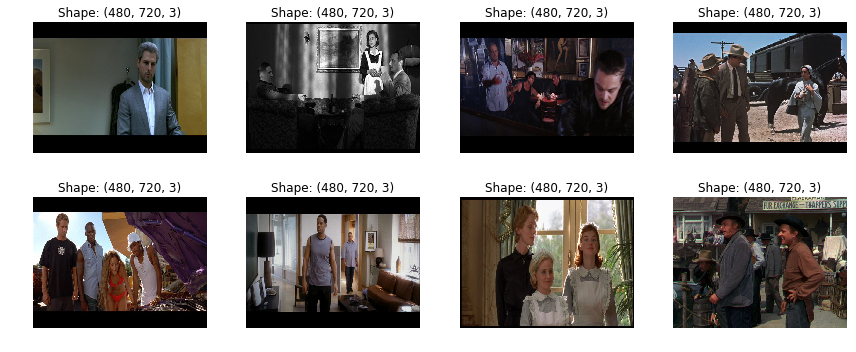

In [14]:
import glob
image_list = glob.glob('FLIC-full/images/*.jpg')[0:8]

plt.figure(figsize=(12,5))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = plt.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Shape: '+str(img.shape))

plt.tight_layout()
plt.show()

In [15]:
def image_cropping(image_id, joints, crop_pad_inf = 1.4, crop_pad_sup=1.6, shift = 5, min_dim = 100):
    """Function to crop original images"""
    ## image cropping
    # load the image 
    image = cv.imread('FLIC-full/images/%s' % (image_id))
    # convert joint list to array 
    joints = np.asarray([int(float(p)) for p in joints])
    # reshape joints to shape (7*2)
    joints = joints.reshape((len(joints) // 2, 2))
    # transform joints to list of (x,y) tuples
    posi_joints = [(j[0], j[1]) for j in joints if j[0] > 0 and j[1] > 0]
    # obtain the bounding rectangle using opencv boundingRect
    x_loc, y_loc, width, height = cv.boundingRect(np.asarray([posi_joints]))
    if width < min_dim:
        width = min_dim
    if height < min_dim:
        height = min_dim

    ## bounding rect extending
    inf, sup = crop_pad_inf, crop_pad_sup
    r = sup - inf
    # define width padding
    pad_w_r = np.random.rand() * r + inf # inf~sup
    # define height padding
    pad_h_r = np.random.rand() * r + inf # inf~sup
    # adjust x, y, w and h by the defined padding
    x_loc -= (width * pad_w_r - width) / 2
    y_loc -= (height * pad_h_r - height) / 2
    width *= pad_w_r
    height *= pad_h_r

    ## shifting
    x_loc += np.random.rand() * shift * 2 - shift
    y_loc += np.random.rand() * shift * 2 - shift

    ## clipping
    x_loc, y_loc, width, height = [int(z) for z in [x_loc, y_loc, width, height]]
    x_loc = np.clip(x_loc, 0, image.shape[1] - 1)
    y_loc = np.clip(y_loc, 0, image.shape[0] - 1)
    width = np.clip(width, 1, image.shape[1] - (x_loc + 1))
    height = np.clip(height, 1, image.shape[0] - (y_loc + 1))
    image = image[y_loc: y_loc + height, x_loc: x_loc + width]

    ## joint shifting
    # adjust joint coordinates onto the padded image
    joints = np.asarray([(j[0] - x_loc, j[1] - y_loc) for j in joints])
    joints = joints.flatten()

    return image, joints

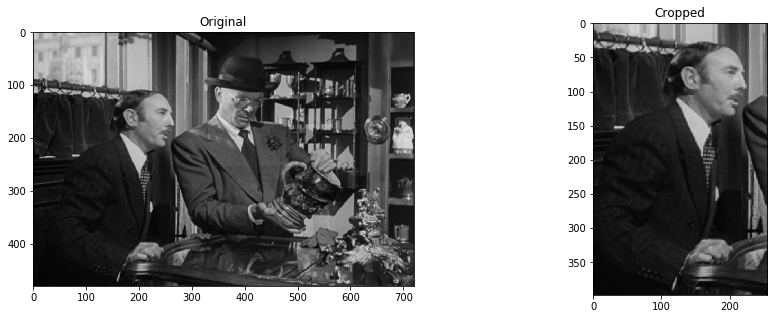

In [16]:
# plot the original image 
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(plt.imread('FLIC-full/images/'+train_image_ids[0]))

# plot the cropped image
image, joint = image_cropping(train_image_ids[0], train_joints[0])
plt.subplot(1,2,2)
plt.title('Cropped')
plt.imshow(image)

In [17]:
def image_resize(image, joints, new_size = 224):
    """Function resize cropped images"""
    orig_h, orig_w = image.shape[:2]
    joints[0::2] = joints[0::2] / float(orig_w) * new_size
    joints[1::2] = joints[1::2] / float(orig_h) * new_size
    image = cv.resize(image, (new_size, new_size), interpolation=cv.INTER_NEAREST)
    return image, joints

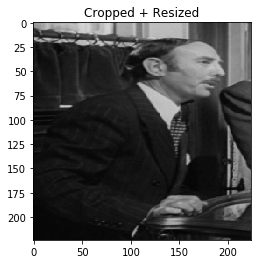

In [18]:
# plot resized image
image, joint = image_resize(image, joint)
plt.title('Cropped + Resized')
plt.imshow(image)

In [19]:
def plot_limb(img, joints, i, j, color):
    """Function to plot the limbs"""
    cv.line(img, joints[i], joints[j], (255, 255, 255), thickness=2, lineType=16)
    cv.line(img, joints[i], joints[j], color, thickness=1, lineType=16)
    return img

def plot_joints(img, joints, groundtruth=True, text_scale=0.5):
    """Function to draw the joints"""
    h, w, c = img.shape
    if groundtruth:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 155, 70))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 155, 70))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 155, 70))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 155, 70))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 155, 70))
        
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 155, 70))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 155, 70), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=2, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    else:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 70, 155))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 70, 155))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 70, 155))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 70, 155))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 70, 155))
       
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 70, 155))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 70, 155), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=3, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    return img

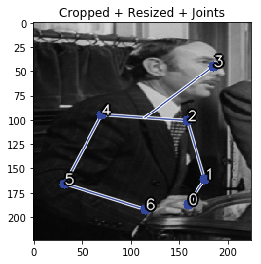

In [20]:
# plot joints on resized image
joints = joint.tolist()
joints = list(zip(joints[0::2], joints[1::2]))

plt.title('Cropped + Resized + Joints')
plt.imshow(plot_joints(image, joints, groundtruth=False, text_scale=0.5))

In [21]:
def model_data(image_ids, joints, train = True):
    """Function to generate train and test data."""
    if train:
        # empty list 
        train_img_joints = []
        
        # create train directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/train')):
            os.mkdir('FLIC-full/train')

        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in train folder
            cv.imwrite('FLIC-full/train/train{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            train_img_joints.append(['train{}.jpg'.format(i)] + joint.tolist())
        
        # convert to a dataframe and save as a csv
        pd.DataFrame(train_img_joints).to_csv('FLIC-full/train/train_joints.csv', index=False, header=False)
    else:
        # empty list 
        test_img_joints = []
        
        # create test directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/test')):
            os.mkdir('FLIC-full/test')
        
        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in test folder
            cv.imwrite('FLIC-full/test/test{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            test_img_joints.append(['test{}.jpg'.format(i)] + joint.tolist())
            
        # convert to a dataframe and save as a csv
        pd.DataFrame(test_img_joints).to_csv('FLIC-full/test/test_joints.csv', index=False, header=False)


model_data(train_image_ids, train_joints, train = True)
model_data(test_image_ids, test_joints, train = False)

In [22]:
K.clear_session()

In [23]:
# Number of epochs
epochs = 3

# Batchsize
batch_size = 128

# Optimizer for the model
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Shape of the input image
input_shape = (224, 224, 3)

# Batch interval at which loss is to be stores
store = 40

In [24]:
# load the vgg16 model 
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = input_shape)

# print summary of vgg16 model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
# set layers as non trainable
for layer in model.layers:
    layer.trainable = False

In [26]:
# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

# Dense layer with 14 neurons for predicting 14 numeric values
predictions = Dense(14, activation="relu")(x)

In [27]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# print summary
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
# compile the model 
model_final.compile(loss = "mean_squared_error", optimizer = optimizer)

In [29]:
# load the train data
train = pd.read_csv('FLIC-full/train/train_joints.csv', header = None)

# split train into train and validation
train_img_ids, val_img_ids, train_jts, val_jts = train_test_split(train.iloc[:,0], train.iloc[:,1:], test_size=0.2, random_state=42)

# load validation images
val_images = np.array([cv.imread('FLIC-full/train/{}'.format(x)) for x in val_img_ids.values])

# convert validation images to dtype float 
val_images = val_images.astype(float)

In [30]:
def training(model, image_ids, joints ,val_images, val_jts, batch_size = 128, epochs=3, store = 40):
    # empty train loss list
    loss_lst = []
    
    # empty validation loss list
    val_loss_lst = []
    
    #counter
    count = 0
    count_lst = []
    
    # create shuffled batches
    batches = np.arange(len(image_ids)//batch_size)
    data_idx = np.arange(len(image_ids))
    random.shuffle(data_idx)
    print('......Training......')
    for epoch in range(epochs):
        for batch in (batches):
            # batch of training image ids
            imgs = image_ids[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # corresponding joints for the above images
            jts = joints[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # load the training image batch
            batch_imgs = np.array([cv.imread('FLIC-full/train/{}'.format(x)) for x in imgs])

            # fit model on the batch
            loss = model.train_on_batch(batch_imgs.astype(float), jts)
            
            if batch%store==0:
                # evaluate model on validation set
                val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
                
                # store train and val loss
                loss_lst.append(loss)
                val_loss_lst.append(val_loss)
                print('Epoch:{}, End of batch:{}, loss:{:.2f}, val_loss:{:.2f}'.format(epoch+1, batch+1, loss, val_loss))
                
                count_lst.append(count)
            else:
                print('Epoch:{}, End of batch:{}, loss:{:.2f}'.format(epoch+1, batch+1, loss))
            count+=1
    count_lst.append(count)
    loss_lst.append(loss)
    val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
    val_loss_lst.append(val_loss)
    print('Epoch:{}, End of batch:{}, VAL_LOSS:{:.2f}'.format(epoch+1, batch+1, val_loss))
    return model, loss_lst, val_loss_lst, count_lst

In [31]:
m, loss_lst, val_loss_lst, count_lst = training(model_final, train_img_ids.values, train_jts.values, val_images, val_jts.values, epochs = epochs, batch_size = batch_size, store = store)

......Training......
Epoch:1, End of batch:1, loss:15108.95, val_loss:13433.66
Epoch:1, End of batch:2, loss:13351.67
Epoch:1, End of batch:3, loss:10308.54
Epoch:1, End of batch:4, loss:6844.49
Epoch:1, End of batch:5, loss:4493.11
Epoch:1, End of batch:6, loss:2447.66
Epoch:1, End of batch:7, loss:2385.18
Epoch:1, End of batch:8, loss:2414.53
Epoch:1, End of batch:9, loss:2691.82
Epoch:1, End of batch:10, loss:2248.67
Epoch:1, End of batch:11, loss:2093.94
Epoch:1, End of batch:12, loss:2028.02
Epoch:1, End of batch:13, loss:1771.39
Epoch:1, End of batch:14, loss:1956.56
Epoch:1, End of batch:15, loss:1816.25
Epoch:1, End of batch:16, loss:1759.51
Epoch:1, End of batch:17, loss:1784.57
Epoch:1, End of batch:18, loss:1725.88
Epoch:1, End of batch:19, loss:1720.37
Epoch:1, End of batch:20, loss:1818.62
Epoch:1, End of batch:21, loss:1683.38
Epoch:1, End of batch:22, loss:1655.85
Epoch:1, End of batch:23, loss:1743.48
Epoch:1, End of batch:24, loss:1701.91
Epoch:1, End of batch:25, loss

Epoch:2, End of batch:104, loss:658.39
Epoch:2, End of batch:105, loss:595.94
Epoch:2, End of batch:106, loss:628.62
Epoch:2, End of batch:107, loss:571.19
Epoch:2, End of batch:108, loss:621.66
Epoch:3, End of batch:1, loss:633.45, val_loss:635.87
Epoch:3, End of batch:2, loss:632.11
Epoch:3, End of batch:3, loss:632.70
Epoch:3, End of batch:4, loss:562.73
Epoch:3, End of batch:5, loss:545.12
Epoch:3, End of batch:6, loss:523.99
Epoch:3, End of batch:7, loss:559.60
Epoch:3, End of batch:8, loss:603.00
Epoch:3, End of batch:9, loss:666.48
Epoch:3, End of batch:10, loss:549.08
Epoch:3, End of batch:11, loss:539.53
Epoch:3, End of batch:12, loss:507.03
Epoch:3, End of batch:13, loss:466.62
Epoch:3, End of batch:14, loss:560.92
Epoch:3, End of batch:15, loss:512.72
Epoch:3, End of batch:16, loss:542.96
Epoch:3, End of batch:17, loss:534.61
Epoch:3, End of batch:18, loss:539.35
Epoch:3, End of batch:19, loss:461.55
Epoch:3, End of batch:20, loss:599.33
Epoch:3, End of batch:21, loss:576.83

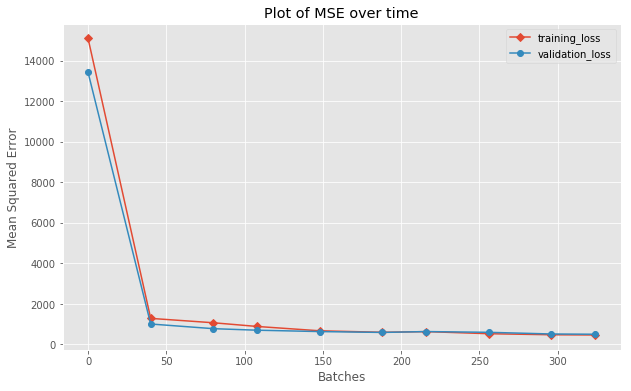

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(count_lst, loss_lst, marker='D', label = 'training_loss')
plt.plot(count_lst, val_loss_lst, marker='o', label = 'validation_loss')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.title('Plot of MSE over time')
plt.legend(loc = 'upper right')
plt.show()

In [33]:
def test(model, nrows=200, batch_size=batch_size):
    # load the train data
    test = pd.read_csv('FLIC-full/test/test_joints.csv', header = None, nrows=nrows)
    test_img_ids = test.iloc[:,0].values
    
    # load validation images
    test_images = np.array([cv.imread('FLIC-full/test/{}'.format(x)) for x in test_img_ids])

    # convert validation images to dtype float 
    test_images = test_images.astype(float)
    
    # joints
    test_joints = test.iloc[:,1:].values
    
    # evaluate
    test_loss = model.evaluate(test_images, test_joints, verbose = 0, batch_size=batch_size)
    
    # predict
    predictions = model.predict(test_images, verbose = 0, batch_size=batch_size)
    # folder to save the results
    if not os.path.exists(os.path.join(os.getcwd(), 'FLIC-full/test_plot')):
        os.mkdir('FLIC-full/test_plot')
    
    for i, (ids, image, joint, pred) in enumerate(zip(test_img_ids, test_images, test_joints, predictions)):
        joints = joint.tolist()
        joints = list(zip(joints[0::2], joints[1::2]))
        # plot original joints
        image = plot_joints(image.astype(np.uint8), joints, groundtruth=True, text_scale=0.5)
        
        pred = pred.astype(np.uint8).tolist()
        pred = list(zip(pred[0::2], pred[1::2]))
        # plot predicted joints
        image = plot_joints(image.astype(np.uint8), pred, groundtruth=False, text_scale=0.5)
        # save resulting images with the same id
        plt.imsave('FLIC-full/test_plot/'+ids, image)
    return test_loss

In [34]:
# test and save results
test_loss = test(m)

# print test_loss
print('Test Loss:', test_loss)

Test Loss: 454.8094494628906


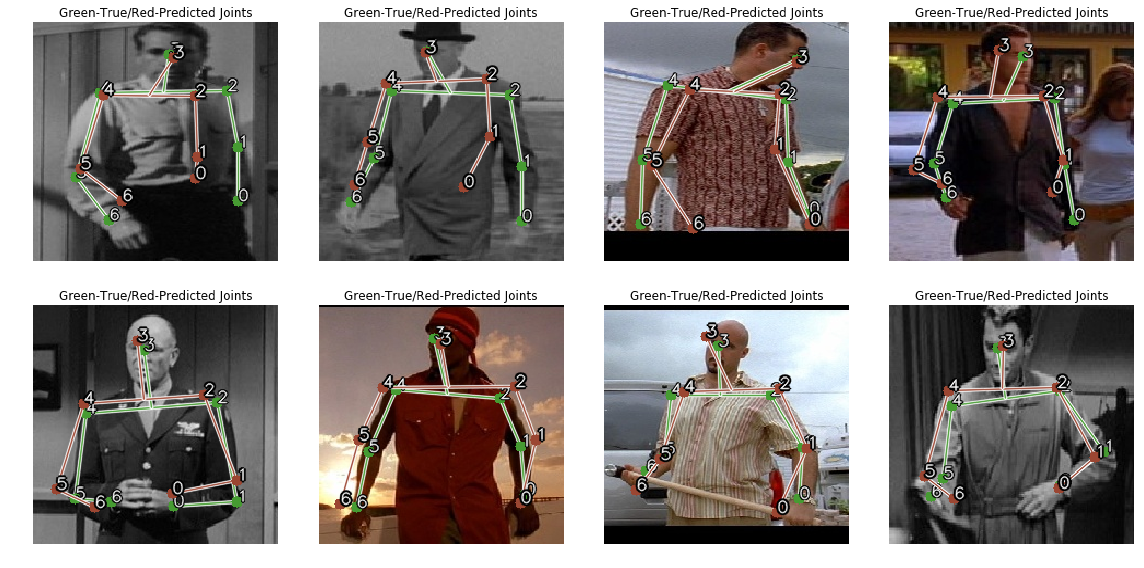

In [7]:
image_list = glob.glob('FLIC-full/test_plot/*.jpg')[8:16]

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = cv.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Green-True/Red-Predicted Joints')

plt.tight_layout()
plt.show()

In [38]:
# save model
model_json = m.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights
m.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [8]:
## Load saved model
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# compile the model
loaded_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5),
                     loss='mean_squared_error')


Loaded model from disk
